In [ ]:
import os
import random
import gym
import pylab
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from keras.optimizers import Adam, RMSprop
from keras import backend as K
import cv2

def OurModel(input_shape, action_space, lr):
    X_input = Input(input_shape)

    #X = Conv2D(32, 8, strides=(4, 4),padding="valid", activation="elu", data_format="channels_first", input_shape=input_shape)(X_input)
    #X = Conv2D(64, 4, strides=(2, 2),padding="valid", activation="elu", data_format="channels_first")(X)
    #X = Conv2D(64, 3, strides=(1, 1),padding="valid", activation="elu", data_format="channels_first")(X)
    X = Flatten(input_shape=input_shape)(X_input)

    X = Dense(512, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(256, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(64, activation="elu", kernel_initializer='he_uniform')(X)

    action = Dense(action_space, activation="softmax", kernel_initializer='he_uniform')(X)
    value = Dense(1, kernel_initializer='he_uniform')(X)

    Actor = Model(inputs = X_input, outputs = action)
    Actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr))

    Critic = Model(inputs = X_input, outputs = value)
    Critic.compile(loss='mse', optimizer=RMSprop(lr=lr))

    return Actor, Critic

class A2CAgent:
    # Actor-Critic Main Optimization Algorithm
    def __init__(self, env_name):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.EPISODES, self.max_average = 10000, -21.0 # specific for pong
        self.lr = 0.000025

        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4

        # Instantiate games and plot memory
        self.states, self.actions, self.rewards = [], [], []
        self.scores, self.episodes, self.average = [], [], []

        self.Save_Path = 'Models'
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        self.image_memory = np.zeros(self.state_size)
        
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_A2C_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        # Create Actor-Critic network model
        self.Actor, self.Critic = OurModel(input_shape=self.state_size, action_space = self.action_size, lr=self.lr)


    def remember(self, state, action, reward):
        # store episode actions to memory
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)


    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        return action

    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: # reset the sum, since this was a game boundary (pong specific!)
                running_add = 0
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= np.std(discounted_r) # divide by standard deviation
        return discounted_r

                
    def replay(self):
        # reshape memory to appropriate shape for training
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)

        # Get Critic network predictions
        values = self.Critic.predict(states)[:, 0]
        # Compute advantages
        advantages = discounted_r - values
        # training Actor and Critic networks
        self.Actor.fit(states, actions, sample_weight=advantages, epochs=1, verbose=0)
        self.Critic.fit(states, discounted_r, epochs=1, verbose=0)
        # reset training memory
        self.states, self.actions, self.rewards = [], [], []
    
    def load(self, Actor_name, Critic_name):
        self.Actor = load_model(Actor_name, compile=False)
        #self.Critic = load_model(Critic_name, compile=False)

    def save(self):
        self.Actor.save(self.Model_name + '_Actor.h5')
        #self.Critic.save(self.Model_name + '_Critic.h5')

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path+".png")
            except OSError:
                pass

        return self.average[-1]

    def imshow(self, image, rem_step=0):
        cv2.imshow(self.Model_name+str(rem_step), image[rem_step,...])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

    def GetImage(self, frame):
        # croping frame to 80x80 size
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function 
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)
        
        # converting to RGB (numpy way)
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]

        # convert everything to black and white (agent will train faster)
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255
        # converting to RGB (OpenCV way)
        #frame_rgb = cv2.cvtColor(frame_cropped, cv2.COLOR_RGB2GRAY)     

        # dividing by 255 we expresses value to 0-1 representation
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)

        # inserting new frame to free space
        self.image_memory[0,:,:] = new_frame

        # show image frame   
        #self.imshow(self.image_memory,0)
        #self.imshow(self.image_memory,1)
        #self.imshow(self.image_memory,2)
        #self.imshow(self.image_memory,3)
        
        return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame)
        return state

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage(next_state)
        return next_state, reward, done, info
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.reset()
            done, score, SAVING = False, 0, ''
            while not done:
                #self.env.render()
                # Actor picks an action
                action = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.step(action)
                # Memorize (state, action, reward) for training
                self.remember(state, action, reward)
                # Update current state
                state = next_state
                score += reward
                if done:
                    average = self.PlotModel(score, e)
                    # saving best models
                    if average >= self.max_average:
                        self.max_average = average
                        self.save()
                        SAVING = "SAVING"
                    else:
                        SAVING = ""
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(e, self.EPISODES, score, average, SAVING))

                    self.replay()
        # close environemnt when finish training
        self.env.close()

    def test(self, Actor_name, Critic_name):
        self.load(Actor_name, Critic_name)
        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                action = np.argmax(self.Actor.predict(state))
                state, reward, done, _ = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
        self.env.close()

if __name__ == "__main__":
    #env_name = 'PongDeterministic-v4'
    env_name = 'Pong-v0'
    agent = A2CAgent(env_name)
    agent.run()

Using TensorFlow backend.


episode: 0/10000, score: -19.0, average: -19.00 SAVING
episode: 1/10000, score: -21.0, average: -20.00 
episode: 2/10000, score: -19.0, average: -19.67 
episode: 3/10000, score: -21.0, average: -20.00 


KeyboardInterrupt: ignored

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
#Policy Gradient for CartPole


import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

class A2CAgent:
  def __init__(self,state_size,action_size):
    self.state_size=state_size
    self.action_size=action_size
    self.gamma=0.99
    self.learning_rate=0.001
    self.states=[]
    self.rewards=[]
    self.labels=[]
    self.prob=[]
    self.Actor=self.build_actor_model()
    self.Critic=self.build_critic_model()
    
    self.Critic.summary()
  
  def build_actor_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Actor=Sequential()
    Actor.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(self.action_size,activation='softmax'))
    Actor.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return Actor
  def build_critic_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Critic=Sequential()
    Critic.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(self.action_size,activation='softmax'))
    Critic.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return Critic


  def memory(self,state,action,prob,reward):
    y=np.zeros([self.action_size])
    y[action]=1
    self.labels.append(np.array(y).astype('float32'))
    self.states.append(state)
    self.rewards.append(reward)

  def act(self,state):
    state=state.reshape([1,state.shape[0]])
    probs=self.Critic.predict(state,batch_size=1).flatten()
    self.prob.append(probs)
    action=np.random.choice(self.action_size,1,p=probs)[0]
    return action,probs

  def discount_rewards(self, rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * self.gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards


  def train(self):
    labels=np.vstack(self.labels)
    rewards=np.vstack(self.rewards)
    rewards=self.discount_rewards(rewards)
    rewards=(rewards-np.mean(rewards))/np.std(rewards)
    labels*=-rewards
    x=np.squeeze(np.vstack([self.states]))
    y=np.squeeze(np.vstack([self.labels]))
    self.Actor.train_on_batch(x,y)
    self.Critic.train_on_batch(x,y)
    self.states,self.probs,self.labels,self.rewards=[],[],[],[]

  def load_model(self,name):
    self.Actor.load_weights(name)
    self.Critic.load_weights(name)
  
  def save_model(self,name):
    self.Actor.save_weights(name)
    
    self.Critic.save_weights(name)
if __name__=="__main__":
  env=gym.make('CartPole-v0')
  
  state=env.reset()
  
  score=0
  episode=0
  state_size=env.observation_space.shape[0]
  action_size=env.action_space.n
  agent=A2CAgent(state_size,action_size)
  j=0
  while j is not 2000:
    screen = env.render(mode='rgb_array')
    action,prob=agent.act(state)
    state_1,reward,done,_=env.step(action)
    score+=reward
    agent.memory(state,action,prob,reward)
    state=state_1
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      j+=1
      agent.rewards[-1]=score
      agent.train()
      print("Episode: %d - Score: %f."%(j,score))
      score=0.0
      state=env.reset()

    env.close()
      

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd0f3e76378> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fd0f3b9e840> (for post_execute):


KeyboardInterrupt: ignored

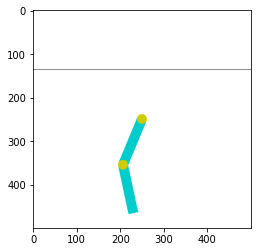

In [ ]:
#Policy Gradient for CartPole


import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

class A2CAgent:
  def __init__(self,state_size,action_size):
    self.state_size=state_size
    self.action_size=action_size
    self.gamma=0.99
    self.learning_rate=0.001
    self.states=[]
    self.rewards=[]
    self.labels=[]
    self.prob=[]
    self.Actor=self.build_actor_model()
    self.Critic=self.build_critic_model()
    
    self.Critic.summary()
  
  def build_actor_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Actor=Sequential()
    Actor.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(self.action_size,activation='softmax'))
    Actor.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return Actor
  def build_critic_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Critic=Sequential()
    Critic.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(self.action_size,activation='softmax'))
    Critic.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return Critic


  def memory(self,state,action,prob,reward):
    y=np.zeros([self.action_size])
    y[action]=1
    self.labels.append(np.array(y).astype('float32'))
    self.states.append(state)
    self.rewards.append(reward)

  def act(self,state):
    state=state.reshape([1,state.shape[0]])
    probs=self.Critic.predict(state,batch_size=1).flatten()
    self.prob.append(probs)
    action=np.random.choice(self.action_size,1,p=probs)[0]
    return action,probs

  def discount_rewards(self, rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * self.gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards


  def train(self):
    labels=np.vstack(self.labels)
    rewards=np.vstack(self.rewards)
    rewards=self.discount_rewards(rewards)
    rewards=(rewards-np.mean(rewards))/np.std(rewards)
    labels*=-rewards
    x=np.squeeze(np.vstack([self.states]))
    y=np.squeeze(np.vstack([self.labels]))
    self.Actor.train_on_batch(x,y)
    self.Critic.train_on_batch(x,y)
    self.states,self.probs,self.labels,self.rewards=[],[],[],[]

  def load_model(self,name):
    self.Actor.load_weights(name)
    self.Critic.load_weights(name)
  
  def save_model(self,name):
    self.Actor.save_weights(name)
    
    self.Critic.save_weights(name)
if __name__=="__main__":
  env=gym.make('Acrobot-v1')
  
  state=env.reset()
  
  score=0
  episode=0
  state_size=env.observation_space.shape[0]
  action_size=env.action_space.n
  agent=A2CAgent(state_size,action_size)
  j=0
  while j is not 2000:
    screen = env.render(mode='rgb_array')
    action,prob=agent.act(state)
    state_1,reward,done,_=env.step(action)
    score+=reward
    agent.memory(state,action,prob,reward)
    state=state_1
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      j+=1
      agent.rewards[-1]=score
      agent.train()
      print("Episode: %d - Score: %f."%(j,score))
      score=0.0
      state=env.reset()

    env.close()
      